In [5]:
import os
import shap
import pm4py as pm
import numpy as np
import pandas as pd
#------------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
#------------------------------------------------------------------
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})
import category_encoders as ce
import itertools
from operator import itemgetter

In [6]:
# input_data_folder = "../input_files"
# in_filename_csv = "sepsis_cases.csv" #change here

in_filename_csv = "test_log.csv" #change here

input_data_folder = "../output_files/20211027_5F23924D_BA61_4C41_ADC0_1B7DE5E7718B/parameters"

https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

In [7]:
path = os.path.join(input_data_folder, in_filename_csv) #path

In [8]:
data = pd.read_csv(path) #read to dataframe

In [9]:
data.iloc[:3] #confirm the load

,caseid,task,user,end_timestamp,open_cases,CRP,LacticAcid,Leucocytes,Diagnose,Age,...,CRP_norm,Diagnose_ohe,Diagnose_ohe_norm,Leucocytes_norm,daytime_norm,weekday_norm,Age_norm,LacticAcid_norm,ac_index,rl_index
0,DHA,ER Registration,A,2014-09-20 16:26:51,91.0,0.0,0.0,0.0,other,65.0,...,0.0,133,133,0.0,0.685312,5,0.722222,0.0,4,2
1,DHA,ER Triage,C,2014-09-20 16:39:22,91.0,0.0,0.0,0.0,other,65.0,...,0.0,133,133,0.0,0.694005,5,0.722222,0.0,6,5
2,DHA,ER Sepsis Triage,A,2014-09-20 16:39:37,91.0,0.0,0.0,0.0,other,65.0,...,0.0,133,133,0.0,0.694178,5,0.722222,0.0,5,2


In [226]:
data['Diagnose'].nunique() #134 unique attributes

134

In [186]:
def scale_feature(log, feature, method, replace=False):
    """Scales a number given a technique.
    Args:
        log: Event-log to be scaled.
        feature: Feature to be scaled.
        method: Scaling method max, lognorm, normal, per activity.
        replace (optional): replace the original value or keep both.
    Returns:
        Scaleded value between 0 and 1.
    """
    scale_args = dict()
    _temp_scale_args = dict()
    if method == 'lognorm':
        log[feature + '_log'] = np.log1p(log[feature])
        max_value = np.max(log[feature+'_log'])
        min_value = np.min(log[feature+'_log'])
        log[feature+'_norm'] = np.divide(
                np.subtract(log[feature+'_log'], min_value), (max_value - min_value))
        log = log.drop((feature + '_log'), axis=1)
        scale_args = {'max_value': max_value, 'min_value': min_value}
    elif method == 'normal':
        max_value = np.max(log[feature])
        min_value = np.min(log[feature])
        log[feature+'_norm'] = np.divide(
                np.subtract(log[feature], min_value), (max_value - min_value))
        scale_args = {'max_value': max_value, 'min_value': min_value}
    elif method == 'standard':
        mean = np.mean(log[feature])
        std = np.std(log[feature])
        log[feature + '_norm'] = np.divide(np.subtract(log[feature], mean),
                                           std)
        scale_args = {'mean': mean, 'std': std}
    elif method == 'max':
        max_value = np.max(log[feature])
        log[feature + '_norm'] = (np.divide(log[feature], max_value)
                                  if max_value > 0 else 0)
        scale_args = {'max_value': max_value}
    elif method == 'day_secs':
        max_value = 86400
        log[feature + '_norm'] = (np.divide(log[feature], max_value)
                                  if max_value > 0 else 0)
        scale_args = {'max_value': max_value}
    elif method is None:
        log[feature+'_norm'] = log[feature]
    else:
        raise ValueError(method)
    if replace:
        log = log.drop(feature, axis=1)
    return log, scale_args

In [187]:
def ordinal_encoder(log, feature, replace=False):
    for i in range(len([feature])):

        cat_label = feature

        temp_list = log[[cat_label]].values.tolist()

        subsec_set = {(x[0]) for x in temp_list}

        subsec_set = sorted(list(subsec_set))

        _index = dict()

        for ix, _ in enumerate(subsec_set):
            _index[subsec_set[ix]] = ix + 1

        _idx = lambda x: _index[x[cat_label]]

        log[cat_label + '_ord'] = log.apply(_idx, axis=1)

        if replace:
            log = log.drop(feature, axis=1)
    return log

In [188]:
# Frequency encoding
fe = data.groupby('Diagnose').size()/len(data)
data.loc[:, 'Diag_freq'] = data['Diagnose'].map(fe)

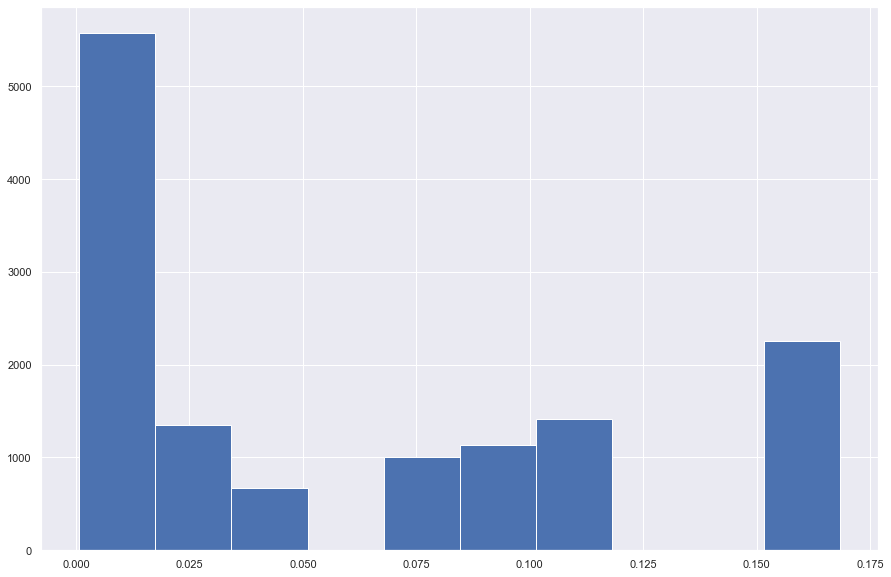

In [189]:
my_data = pd.Series(data['Diag_freq'])
my_data.hist()

In [197]:
data = ordinal_encoder(data, 'Diagnose')

In [198]:
data.iloc[:3]

,Case ID,Activity,Complete Timestamp,user,open_cases,CRP,LacticAcid,Leucocytes,Diagnose,Age,Diag_freq,Diagnose_ord,Diagnose_ord_norm
0,XJ,ER Registration,2013-11-07 07:18:29+00:00,A,1,0.0,0.0,0.0,C,90.0,0.16838,12,0.089552
1,XJ,ER Triage,2013-11-07 07:29:18+00:00,C,1,0.0,0.0,0.0,C,90.0,0.16838,12,0.089552
2,XJ,ER Sepsis Triage,2013-11-07 07:37:32+00:00,A,1,0.0,0.0,0.0,C,90.0,0.16838,12,0.089552


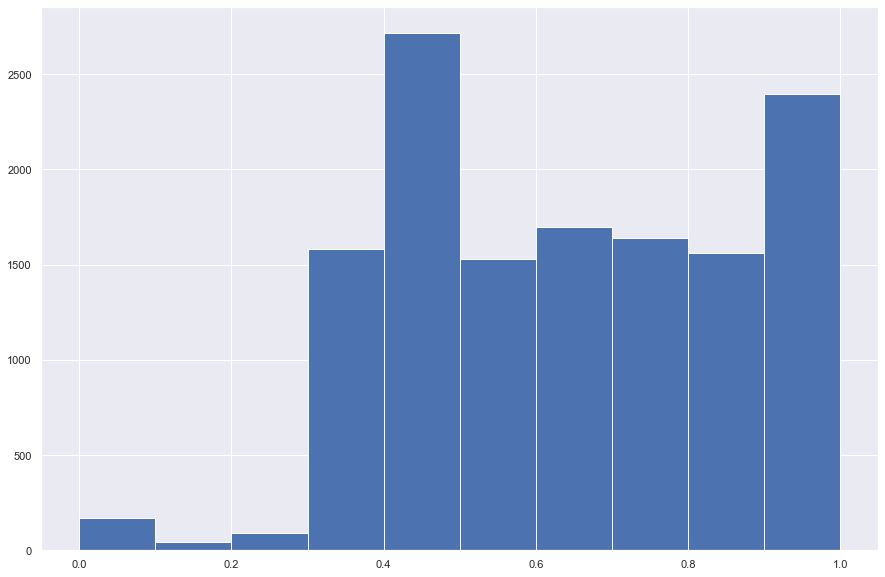

In [199]:
data, _ = scale_feature(data, 'Diagnose_ord', 'lognorm')
my_data = pd.Series(data['Diagnose_ord_norm'])
my_data.hist()

In [200]:
data.iloc[:3]

,Case ID,Activity,Complete Timestamp,user,open_cases,CRP,LacticAcid,Leucocytes,Diagnose,Age,Diag_freq,Diagnose_ord,Diagnose_ord_norm
0,XJ,ER Registration,2013-11-07 07:18:29+00:00,A,1,0.0,0.0,0.0,C,90.0,0.16838,12,0.444384
1,XJ,ER Triage,2013-11-07 07:29:18+00:00,C,1,0.0,0.0,0.0,C,90.0,0.16838,12,0.444384
2,XJ,ER Sepsis Triage,2013-11-07 07:37:32+00:00,A,1,0.0,0.0,0.0,C,90.0,0.16838,12,0.444384


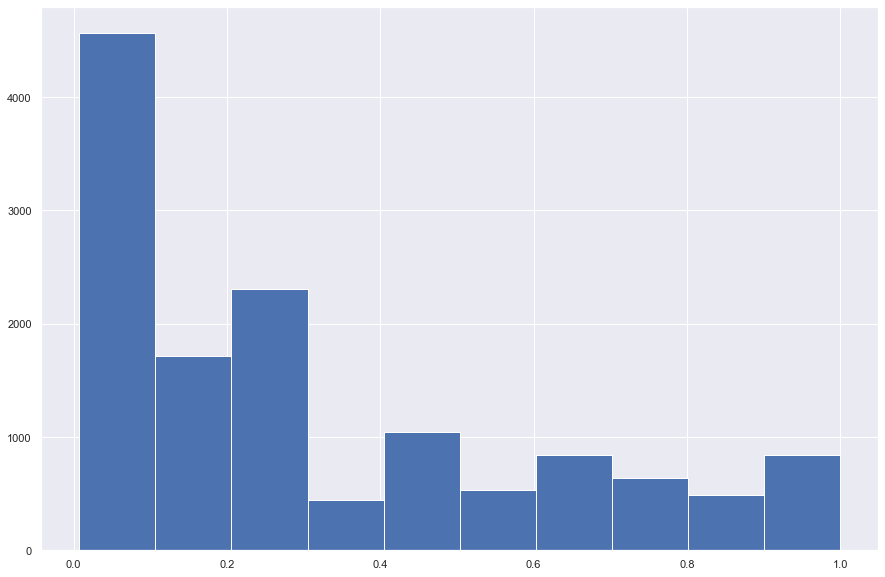

In [209]:
data, _ = scale_feature(data, 'Diagnose_ord', 'max')
my_data = pd.Series(data['Diagnose_ord_norm'])
my_data.hist()

In [210]:
data.iloc[:3]

,Case ID,Activity,Complete Timestamp,user,open_cases,CRP,LacticAcid,Leucocytes,Diagnose,Age,Diag_freq,Diagnose_ord,Diagnose_ord_norm
0,XJ,ER Registration,2013-11-07 07:18:29+00:00,A,1,0.0,0.0,0.0,C,90.0,0.16838,12,0.089552
1,XJ,ER Triage,2013-11-07 07:29:18+00:00,C,1,0.0,0.0,0.0,C,90.0,0.16838,12,0.089552
2,XJ,ER Sepsis Triage,2013-11-07 07:37:32+00:00,A,1,0.0,0.0,0.0,C,90.0,0.16838,12,0.089552


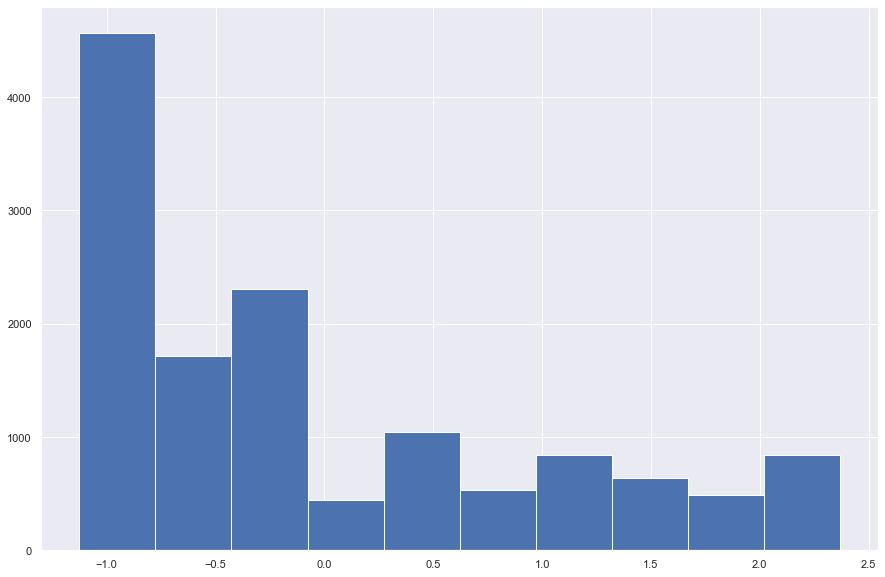

In [211]:
data, _ = scale_feature(data, 'Diagnose_ord', 'standard')
my_data = pd.Series(data['Diagnose_ord_norm'])
my_data.hist()

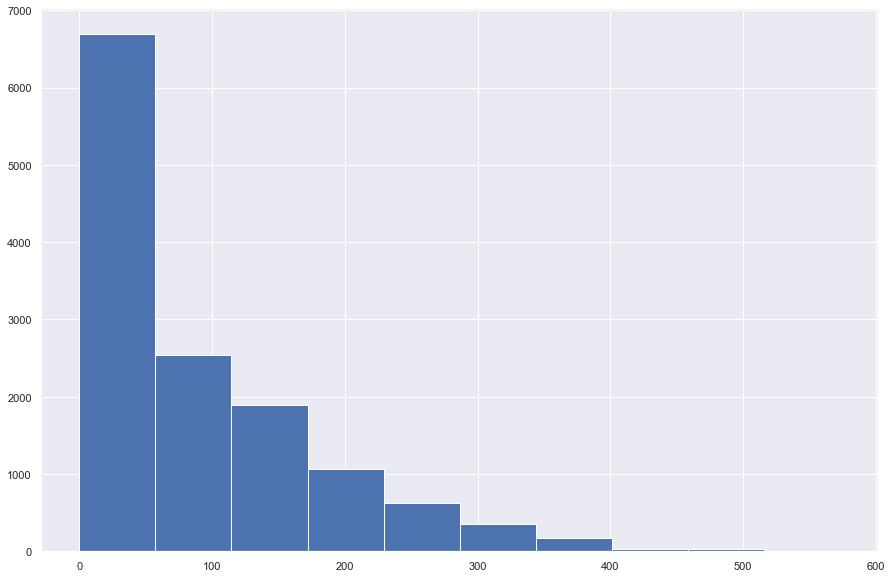

In [212]:
my_data = pd.Series(data['CRP'])
my_data.hist()

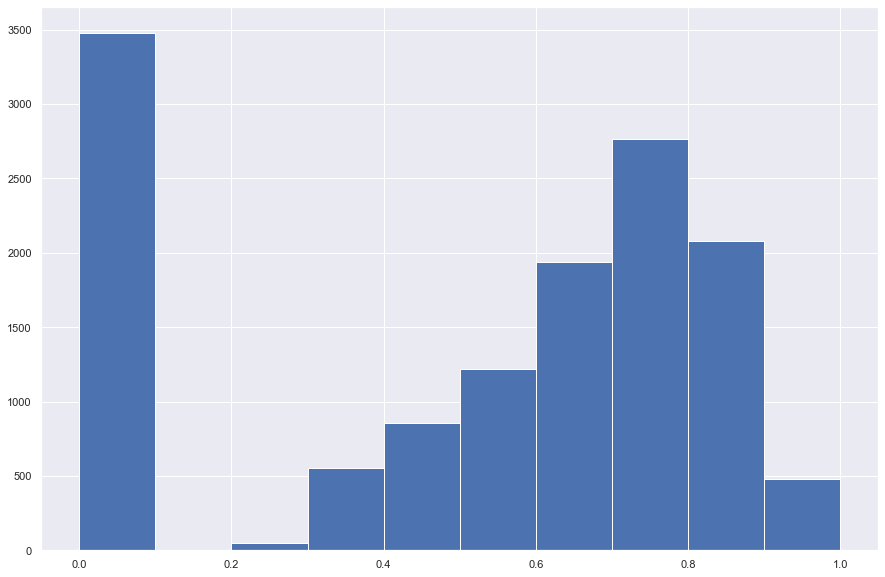

In [218]:
data, _ = scale_feature(data, 'CRP', 'lognorm')
my_data = pd.Series(data['CRP_norm'])
my_data.hist()

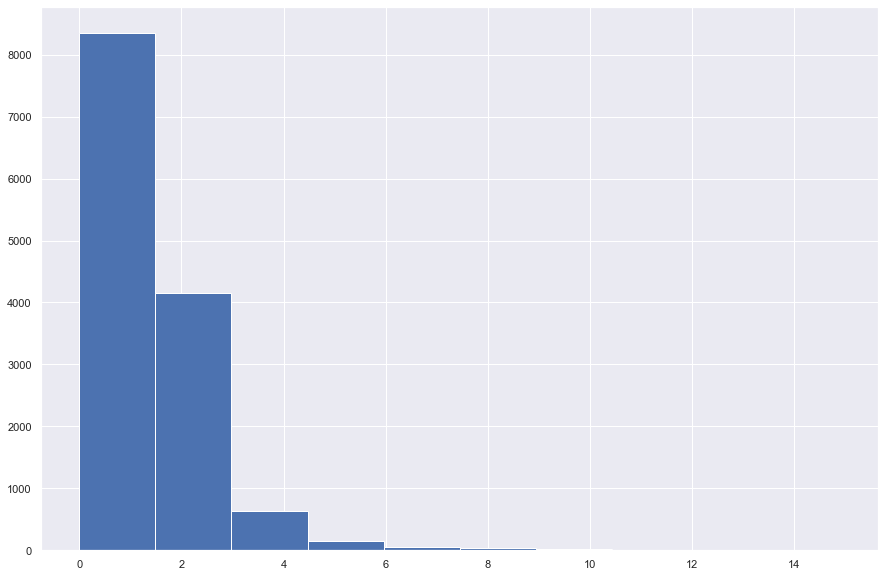

In [219]:
my_data = pd.Series(data['LacticAcid'])
my_data.hist()

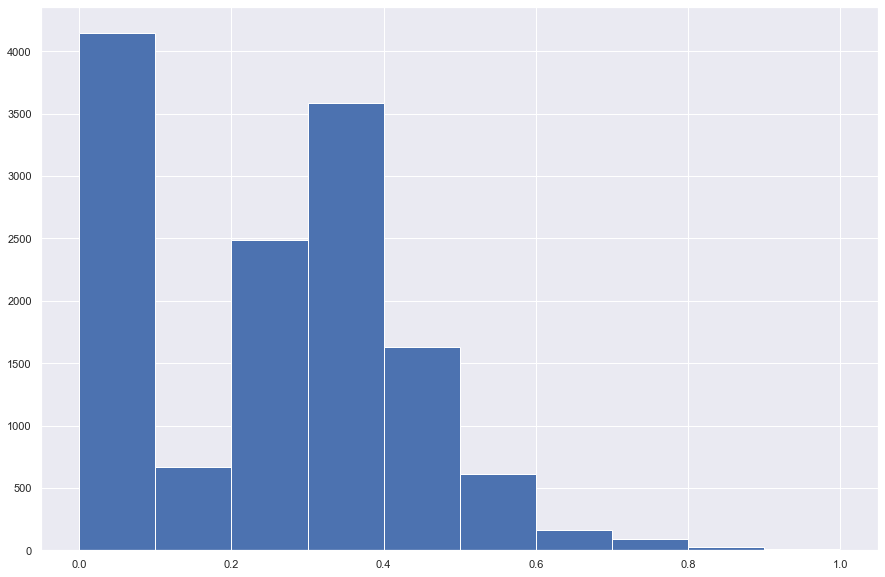

In [222]:
data, _ = scale_feature(data, 'LacticAcid', 'lognorm')
my_data = pd.Series(data['LacticAcid_norm'])
my_data.hist()

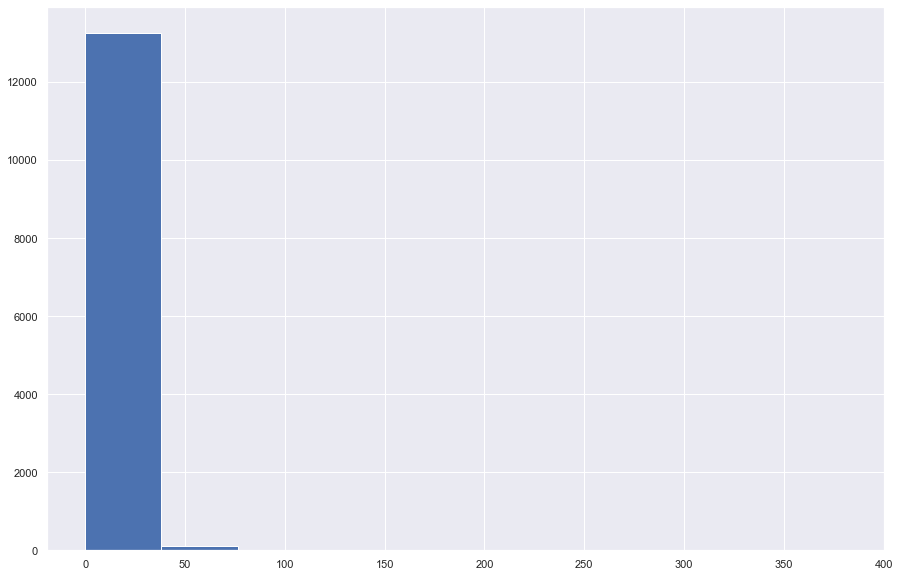

In [223]:
my_data = pd.Series(data['Leucocytes'])
my_data.hist()

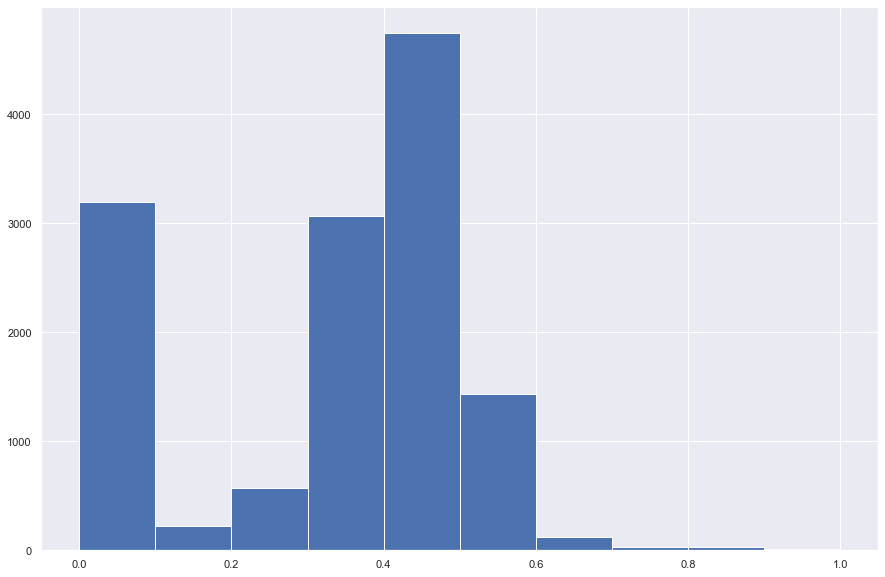

In [224]:
data, _ = scale_feature(data, 'Leucocytes', 'lognorm')
my_data = pd.Series(data['Leucocytes_norm'])
my_data.hist()

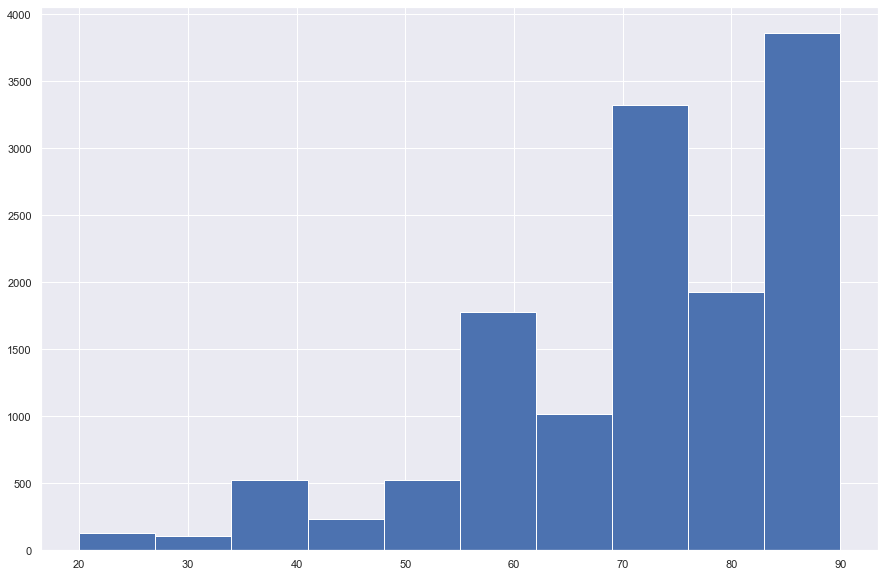

In [225]:
my_data = pd.Series(data['Age'])
my_data.hist()

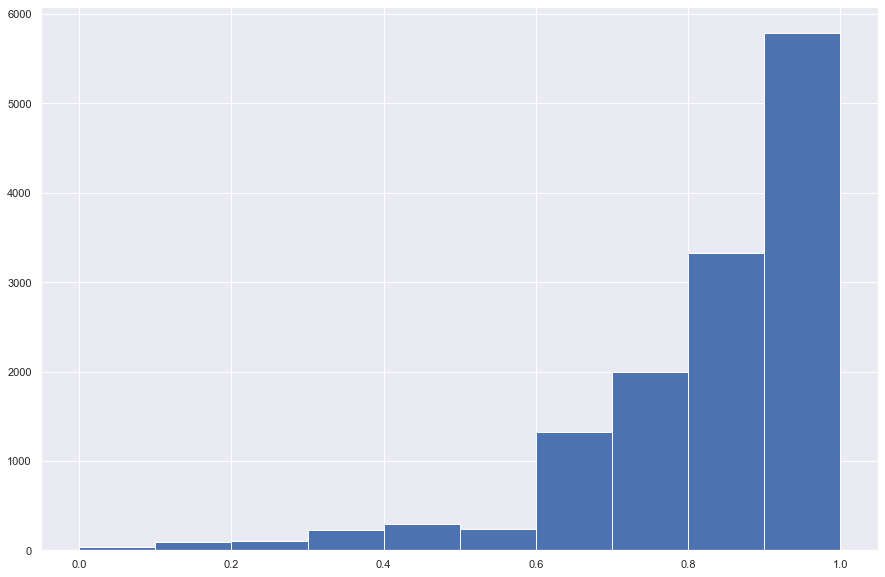

In [228]:
data, _ = scale_feature(data, 'Age', 'lognorm')
my_data = pd.Series(data['Age_norm'])
my_data.hist()

In [229]:
# Frequency encoding
fe = data.groupby('Age').size()/len(data)
data.loc[:, 'Age_freq'] = data['Age'].map(fe)

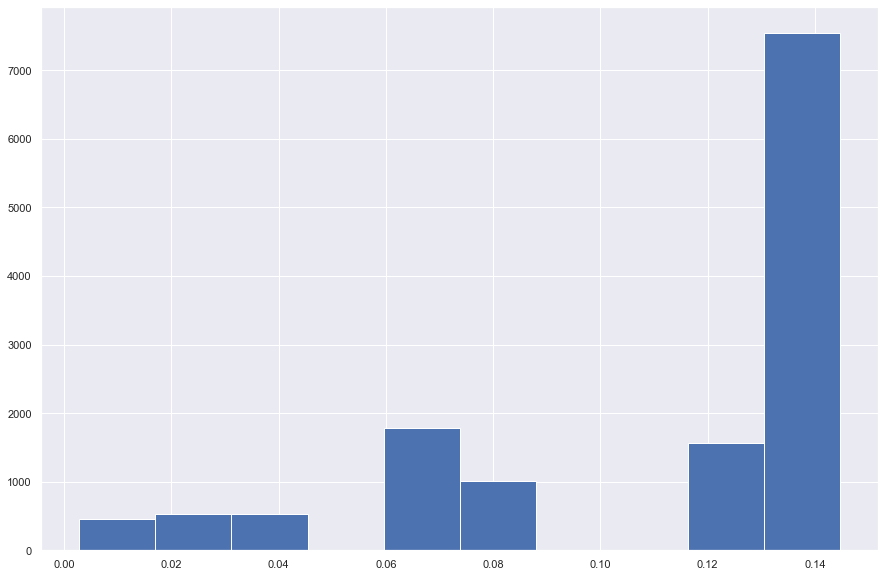

In [230]:
my_data = pd.Series(data['Age_freq'])
my_data.hist()

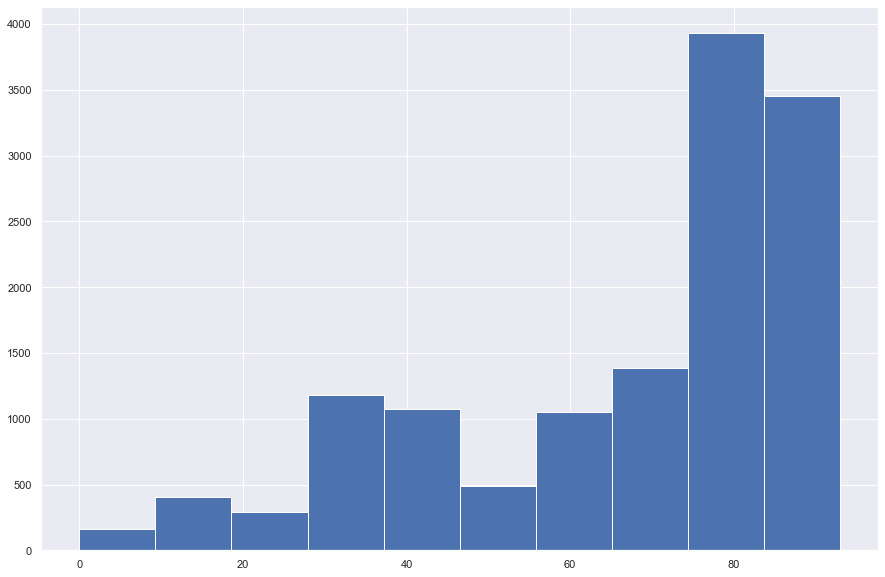

In [231]:
my_data = pd.Series(data['open_cases'])
my_data.hist()

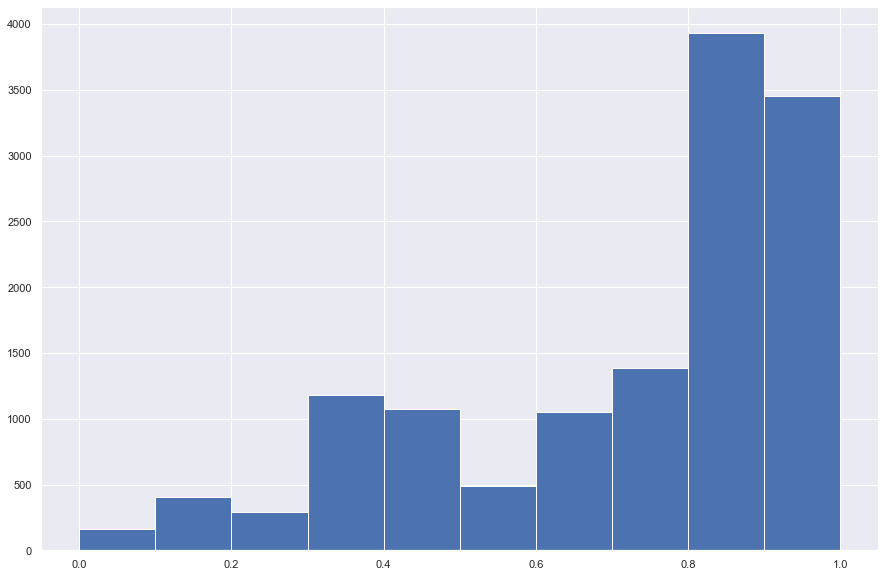

In [248]:
data, _ = scale_feature(data, 'open_cases', 'max')
my_data = pd.Series(data['open_cases_norm'])
my_data.hist()

In [249]:
# Frequency encoding
fe = data.groupby('open_cases').size()/len(data)
data.loc[:, 'open_cases_freq'] = data['open_cases'].map(fe)

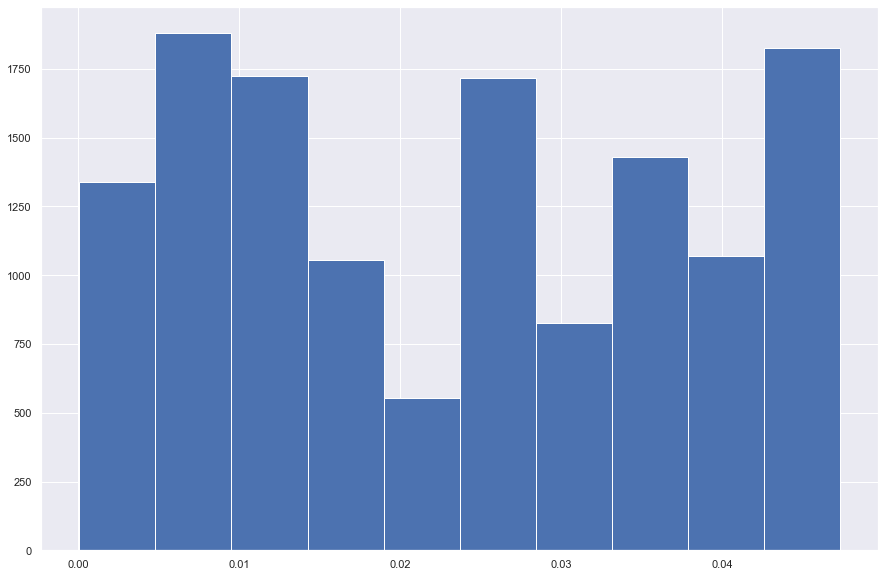

In [250]:
my_data = pd.Series(data['open_cases_freq'])
my_data.hist()

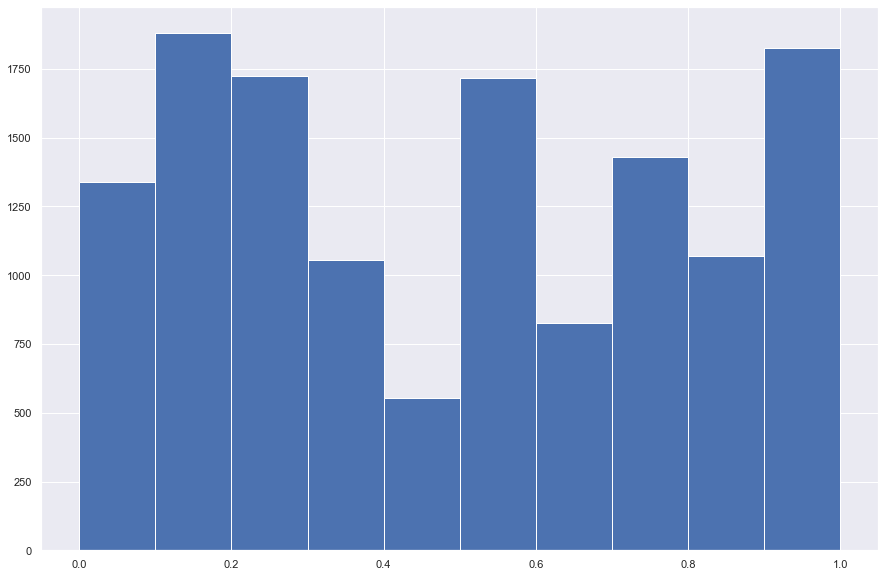

In [244]:
data, _ = scale_feature(data, 'open_cases_freq', 'lognorm')
my_data = pd.Series(data['open_cases_freq_norm'])
my_data.hist()

In [242]:
data.iloc[:3]

,Case ID,Activity,Complete Timestamp,user,open_cases,CRP,LacticAcid,Leucocytes,Diagnose,Age,...,Diagnose_ord,Diagnose_ord_norm,CRP_norm,LacticAcid_norm,Leucocytes_norm,Age_norm,Age_freq,open_cases_norm,open_cases_freq,open_cases_freq_norm
0,XJ,ER Registration,2013-11-07 07:18:29+00:00,A,1,0.0,0.0,0.0,C,90.0,...,12,-0.836999,0.0,0.0,0.0,1.0,0.143123,0.010753,0.00082,0.017323
1,XJ,ER Triage,2013-11-07 07:29:18+00:00,C,1,0.0,0.0,0.0,C,90.0,...,12,-0.836999,0.0,0.0,0.0,1.0,0.143123,0.010753,0.00082,0.017323
2,XJ,ER Sepsis Triage,2013-11-07 07:37:32+00:00,A,1,0.0,0.0,0.0,C,90.0,...,12,-0.836999,0.0,0.0,0.0,1.0,0.143123,0.010753,0.00082,0.017323


In [ ]:
data, _ = scale_feature(data, 'CRP', 'lognorm')
my_data = pd.Series(data['CRP_norm'])
my_data.hist()

In [ ]:
data, _ = scale_feature(data, 'open_cases_freq', 'lognorm')
my_data = pd.Series(data['open_cases_freq_norm'])
my_data.hist()

In [245]:
# Frequency encoding
fe = data.groupby('CRP').size()/len(data)
data.loc[:, 'CRP_freq'] = data['CRP'].map(fe)

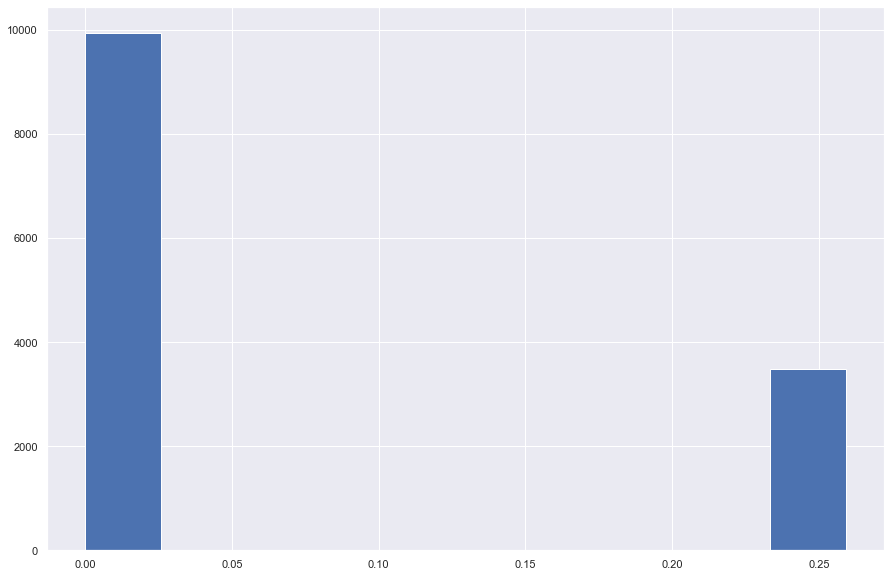

In [246]:
my_data = pd.Series(data['CRP_freq'])
my_data.hist()

In [261]:
def add_calculated_times(log):
    log['dur'] = 0
    log['daytime'] = 0
    log = log.to_dict('records')
    log = sorted(log, key=lambda x: x['caseid'])
    for _, group in itertools.groupby(log, key=lambda x: x['caseid']):
        events = list(group)
        ordk = 'end_timestamp'
        events = sorted(events, key=itemgetter(ordk))
        for i in range(0, len(events)):
            if i == 0:
                dur = 0
                acc = 0
            else:
                dur = (events[i]['end_timestamp'] -
                       events[i-1]['end_timestamp']).total_seconds()
                acc = (events[i]['end_timestamp'] -
                       events[0]['end_timestamp']).total_seconds()

            events[i]['dur'] = dur
            time = events[i][ordk].time()
            time = time.second + time.minute*60 + time.hour*3600
            events[i]['daytime'] = time
            events[i]['weekday'] = events[i]['end_timestamp'].weekday()
    return pd.DataFrame.from_dict(log)

In [262]:
data = data.rename(columns={'Case ID': 'caseid', 'Complete Timestamp': 'end_timestamp'})

In [263]:
data.iloc[:3]

,caseid,Activity,end_timestamp,user,open_cases,CRP,LacticAcid,Leucocytes,Diagnose,Age,dur,daytime
0,XJ,ER Registration,2013-11-07 07:18:29+00:00,A,1,0.0,0.0,0.0,C,90.0,0,0
1,XJ,ER Triage,2013-11-07 07:29:18+00:00,C,1,0.0,0.0,0.0,C,90.0,0,0
2,XJ,ER Sepsis Triage,2013-11-07 07:37:32+00:00,A,1,0.0,0.0,0.0,C,90.0,0,0


In [264]:
time_data = add_calculated_times(data)

AttributeError: 'str' object has no attribute 'time'

In [267]:
log = data.to_dict('records')

In [4]:
pip install tensorflow

  Using cached tensorflow-2.6.0-cp38-cp38-win_amd64.whl (423.2 MB)
  Using cached clang-5.0-py3-none-any.whl
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.1.0-cp38-cp38-win_amd64.whl (2.7 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-0.14.1-py3-none-any.whl (131 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import keras.utils as ku

In [45]:
x = [[0], [0, 5], [0, 5, 5], [0, 5, 5, 5], [0, 5, 5, 5, 5], [0, 5, 5, 5, 5, 5], [0, 5, 5, 5, 5, 5, 5], [0, 5, 5, 5, 5, 5, 5, 6]]

In [46]:
y = [5, 5, 5, 5, 5, 5, 6, 3]

In [6]:
x = ku.to_categorical(x, num_classes=7)

AttributeError: module 'keras.utils' has no attribute 'to_categorical'

In [9]:
y = ku.to_categorical(y, num_classes=7)

AttributeError: module 'keras.utils' has no attribute 'to_categorical'

In [15]:
from keras.utils import np_utils

In [19]:
x

[[0],
 [0, 5],
 [0, 5, 5],
 [0, 5, 5, 5],
 [0, 5, 5, 5, 5],
 [0, 5, 5, 5, 5, 5],
 [0, 5, 5, 5, 5, 5, 5],
 [0, 5, 5, 5, 5, 5, 5, 6]]

In [24]:
np.array(x)

array([list([0]), list([0, 5]), list([0, 5, 5]), list([0, 5, 5, 5]),
       list([0, 5, 5, 5, 5]), list([0, 5, 5, 5, 5, 5]),
       list([0, 5, 5, 5, 5, 5, 5]), list([0, 5, 5, 5, 5, 5, 5, 6])],
      dtype=object)

In [27]:
np_utils.to_categorical(x, num_classes=7)

ValueError: setting an array element with a sequence.

In [28]:
x

[[0],
 [0, 5],
 [0, 5, 5],
 [0, 5, 5, 5],
 [0, 5, 5, 5, 5],
 [0, 5, 5, 5, 5, 5],
 [0, 5, 5, 5, 5, 5, 5],
 [0, 5, 5, 5, 5, 5, 5, 6]]

In [31]:
z = np.array(y, dtype='int')

In [32]:
z

array([5, 5, 5, 5, 5, 5, 6, 3])

In [33]:
np_utils.to_categorical(y, num_classes=7)

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [52]:
x = [[0], [0, 5], [0, 5, 5], [0, 5, 5, 5], [0, 5, 5, 5, 5], [0, 5, 5, 5, 5, 5], [0, 5, 5, 5, 5, 5, 5], [0, 5, 5, 5, 5, 5, 5, 6]]

In [44]:
np_utils.to_categorical(x, num_classes=7)

array([[[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]]], dtype=float32)

In [53]:
len(max(x, key=len))

8

In [50]:
b = np.zeros([len(a),len(max(a,key = lambda x: len(x)))])

In [51]:
b

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [57]:
a = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]
import numpy as np
b = np.zeros([len(a),len(max(a,key = lambda x: len(x)))])

In [58]:
b

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [69]:
for i,j in enumerate(a):
    print(j)
    b[i][0:len(j)] = j

[1, 2, 3]
[4, 5]
[6, 7, 8, 9]



IndexError: index 3 is out of bounds for axis 0 with size 3

In [64]:
N = 5

In [65]:
a += [''] * (N - len(a))

In [66]:
a

[[1, 2, 3], [4, 5], [6, 7, 8, 9], '', '']

In [101]:
# a = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]
a = x
import numpy as np
b = np.zeros([len(a),len(max(a,key = lambda x: len(x)))])

In [102]:
b

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [103]:
for i,j in enumerate(a): b[i][-len(j):] = j

In [104]:
b

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 5.],
       [0., 0., 0., 0., 0., 0., 5., 5.],
       [0., 0., 0., 0., 0., 5., 5., 5.],
       [0., 0., 0., 0., 5., 5., 5., 5.],
       [0., 0., 0., 5., 5., 5., 5., 5.],
       [0., 0., 5., 5., 5., 5., 5., 5.],
       [0., 5., 5., 5., 5., 5., 5., 6.]])

In [96]:
x

[[0],
 [0, 5],
 [0, 5, 5],
 [0, 5, 5, 5],
 [0, 5, 5, 5, 5],
 [0, 5, 5, 5, 5, 5],
 [0, 5, 5, 5, 5, 5, 5],
 [0, 5, 5, 5, 5, 5, 5, 6]]

In [87]:
b[0][3:]

array([0.])

In [98]:
np_utils.to_categorical(b, num_classes=7)

array([[[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]],

       [[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0.]],

       [[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
      

In [106]:
z = x

In [107]:
new_row = [np.array(x) for x in z]

In [108]:
new_row

[array([0]),
 array([0, 5]),
 array([0, 5, 5]),
 array([0, 5, 5, 5]),
 array([0, 5, 5, 5, 5]),
 array([0, 5, 5, 5, 5, 5]),
 array([0, 5, 5, 5, 5, 5, 5]),
 array([0, 5, 5, 5, 5, 5, 5, 6])]

In [136]:
s = [[[0, 0, 0, 0, 0, 0, 0]]]

In [137]:
t = [[[1, 2, 3, 4, 5, 6, 7]]]

In [138]:
v = [[[0, 0, 0, 0, 0, 0, 5]]]

In [139]:
f=list()

In [140]:
f.append(np.concatenate([t, v], axis=2))

In [141]:
f

[array([[[1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 5]]])]

In [142]:
a = np.array([[[1, 2], [3, 4]]])
b = np.array([[[5, 6]]])

In [155]:
new_row = np.array([[0, 0, 0, 0, 0, 0, 0]])

In [156]:
new_row.shape[1]

7

In [157]:
new_row.shape[2]

IndexError: tuple index out of range

In [ ]:
new_row = new_row.reshape((new_row.shape[1], new_row.shape[2]))

In [214]:
t = [0, 0, 0, 0, 0, 0, 0]

In [215]:
y = [0, 0, 0, 0, 0, 0, 0]

In [217]:
g = np.concatenate([t, y], axis=0).tolist()

In [218]:
g

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [188]:
list(g)[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [173]:
a = np.uint32([1, 2])

In [174]:
a

array([1, 2], dtype=uint32)

In [175]:
a_list = list(a)

In [176]:
a_list

[1, 2]

In [202]:
a = np.array([[1, 2], [3, 4]])

In [203]:
a

array([[1, 2],
       [3, 4]])

In [204]:
list(a)

[array([1, 2]), array([3, 4])]

In [205]:
a.tolist()

[[1, 2], [3, 4]]

In [264]:
df = pd.DataFrame(
    {'trial_num': [1, 2, 3, 1, 2, 3],
     'subject': [1, 1, 1, 2, 2, 2],
     'samples': [list(np.random.randn(3).round(2)) for i in range(6)]
    }
)

In [265]:
df

,trial_num,subject,samples
0,1,1,"[-1.56, -1.4, 2.52]"
1,2,1,"[-0.27, 1.98, -0.64]"
2,3,1,"[1.42, -0.26, -0.57]"
3,1,2,"[0.57, 1.18, 0.37]"
4,2,2,"[0.26, -1.18, 0.35]"
5,3,2,"[-0.09, 0.51, 0.4]"


In [266]:
dataTypeSeries = df.dtypes

In [267]:
print(dataTypeSeries)

trial_num     int64
subject       int64
samples      object
dtype: object


In [268]:
df['samples'].dtypes

dtype('O')

In [269]:
df['trial_num'].dtypes

dtype('int64')

In [270]:
pd.set_option('mode.chained_assignment', None)

In [271]:
if df['samples'].dtypes == 'O':
    for i in range(len(df['samples'])):
        s = list()
        for j in range(len(df['samples'][i])):
            s.append(abs(df['samples'][i][j]))
        df['samples'][i] = s

In [255]:
df

,trial_num,subject,samples
0,1,1,"[1.22, 0.52, 1.17]"
1,2,1,"[1.19, 1.66, 0.85]"
2,3,1,"[1.01, 0.35, 0.1]"
3,1,2,"[2.43, 0.01, 1.17]"
4,2,2,"[0.13, 0.96, 1.2]"
5,3,2,"[1.05, 1.5, 0.31]"


In [2]:
pred = [[[4, 10, 5], [2, 4, 5], [0.0006753882, 0.0006753882, 0.0006753882]], [[6, 4, 6], [5, 2, 4], [0.000614388, 0.00058750575, 0.00065208576]], [[5, 6, 9], [4, 2, 4], [0.0006155963, 0.00061659334, 0.00061041105]]]

In [3]:
pred

[[[4, 10, 5], [2, 4, 5], [0.0006753882, 0.0006753882, 0.0006753882]],
 [[6, 4, 6], [5, 2, 4], [0.000614388, 0.00058750575, 0.00065208576]],
 [[5, 6, 9], [4, 2, 4], [0.0006155963, 0.00061659334, 0.00061041105]]]

In [29]:
_ac = [0, 4.0, 6.0]

In [6]:
ini[:1]

[0]

In [7]:
_pos = [6, 4, 6]

In [12]:
pred[1][0]

[6, 4, 6]

In [28]:
 _ac[:1] + _pos

[0, 6, 4, 6]

In [71]:
for lk in range(3):
    _ot = list()
    for gk in range(len(pred)):
        _ot.append([float(pred[gk][2][lk])])
#     _ot = _ac[:1] + _ot
    print(_ot)

[[0.0006753882], [0.000614388], [0.0006155963]]
[[0.0006753882], [0.00058750575], [0.00061659334]]
[[0.0006753882], [0.00065208576], [0.00061041105]]


In [72]:
_ot

[[0.0006753882], [0.00065208576], [0.00061041105]]

In [47]:
type(tm)

numpy.ndarray

In [48]:
tm

array([[0],
       [0]])

In [50]:
tm[:1][0]

array([0])

In [97]:
tem_tm = np.array([[0.00067539]])

In [98]:
np.concatenate((tm[:1], tem_tm), axis=0)

array([[0.        ],
       [0.00067539]])

In [63]:
xc = np.concatenate((tm[:1], np.array([tem_tm])), axis=0)

In [64]:
type(xc)

numpy.ndarray

In [74]:
[[0.00067539], [0.00061439]]

[[0.00067539], [0.00061439]]

In [86]:
np.dstack([[0.00067539, 0.00061439]])[0]

array([[0.00067539],
       [0.00061439]])

In [81]:
z

[[[0.00067539], [0.00061439]]]

In [88]:
np.dstack([0.00067539])[0]

array([[0.00067539]])

In [15]:
_temp_ac = list()
_temp_rl = list()
_temp_tm = list()

In [16]:
preds_prefix = [[4, 2, 0.0006753882], [6, 5, 0.000614388], [5, 4, 0.0006155963]]

In [17]:
for lk in range(1):
        for gk in range(len(preds_prefix)):
            _temp_ac.append(float(preds_prefix[gk][2]))

In [21]:
_tm = np.array([[0], [0]])

In [19]:
_temp_ac

[0.0006753882, 0.000614388, 0.0006155963]

In [22]:
_temp_tm = np.concatenate((_tm[:1], np.dstack([_temp_ac])[0]), axis=0)

In [23]:
_temp_tm

array([[0.        ],
       [0.00067539],
       [0.00061439],
       [0.0006156 ]])

In [36]:
arr = [[6, 8, 3], [5, 4, 2], 0.0007641611, [0.9507976, 0.011135282, 0.010417458], [0.9442697, 0.033864975, 0.021394823]]

In [11]:
pred = [0, 4.0]

In [12]:
for i in range(3):
    pred.append(arr[0][i])
    print(pred)
    del pred[-1]

[0, 4.0, 6]
[0, 4.0, 8]
[0, 4.0, 3]


In [18]:
pred

[0, 4.0]

In [44]:
tm = np.array([[0.00000000e+00],
 [0.00000000e+00],
 [2.08314159e-05]])

In [45]:
tm.shape

(3, 1)

In [33]:
tm.append([float(arr[2])])

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [39]:
tm

array([[0.00000000e+00],
       [0.00000000e+00],
       [2.08314159e-05]])

In [75]:
tm = [[0]]

In [83]:
tm = np.array([[0.00000000e+00],
 [0.00000000e+00],
 [2.08314159e-05]])

In [84]:
t = np.concatenate((tm, np.array([[arr[2]]])))

In [77]:
print(t)

[[0.        ]
 [0.00076416]]


In [78]:
t = t[:-1]

In [86]:
type(tm.shape)

tuple

In [82]:
np.zeros(shape[tm.shape])

NameError: name 'shape' is not defined

In [87]:
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]

SyntaxError: invalid syntax (Temp/ipykernel_14420/3924968939.py, line 1)

In [88]:
[-1, -2]

[-1, -2]

In [89]:
abs([-1, -2])

TypeError: bad operand type for abs(): 'list'

In [103]:
a = [1, 2, 3]

In [104]:
a.clear()

In [10]:
data.iloc[:3] #confirm the load

,caseid,task,user,end_timestamp,open_cases,CRP,LacticAcid,Leucocytes,Diagnose,Age,...,CRP_norm,Diagnose_ohe,Diagnose_ohe_norm,Leucocytes_norm,daytime_norm,weekday_norm,Age_norm,LacticAcid_norm,ac_index,rl_index
0,DHA,ER Registration,A,2014-09-20 16:26:51,91.0,0.0,0.0,0.0,other,65.0,...,0.0,133,133,0.0,0.685312,5,0.722222,0.0,4,2
1,DHA,ER Triage,C,2014-09-20 16:39:22,91.0,0.0,0.0,0.0,other,65.0,...,0.0,133,133,0.0,0.694005,5,0.722222,0.0,6,5
2,DHA,ER Sepsis Triage,A,2014-09-20 16:39:37,91.0,0.0,0.0,0.0,other,65.0,...,0.0,133,133,0.0,0.694178,5,0.722222,0.0,5,2


In [86]:
ykk = data.groupby(["Diagnose", "Age", "caseid"])["caseid"].count()

In [87]:
ykk = ykk.to_frame()

In [69]:
gkk = data.groupby(["Diagnose", "Age"])["caseid"]

In [70]:
gkk = gkk.first()

In [61]:
print(type(gkk), gkk)

<class 'pandas.core.series.Series'> Diagnose  Age 
A         85.0      A
          90.0     IF
AA        65.0     NV
          75.0    ALA
B         35.0    MKA
                 ... 
ZA        70.0    IAA
          75.0    ZGA
          80.0     KI
missing   80.0     BM
other     65.0    DHA
Name: caseid, Length: 136, dtype: object


In [62]:
gkk = gkk.to_frame()

In [91]:
print(ykk.columns)

Index(['caseid'], dtype='object')


In [95]:
ykk = ykk.rename(columns = {'caseid':'count'})

In [96]:
gkk = ykk.reset_index(level=["Diagnose", "Age", "caseid"])

In [97]:
print(type(gkk), gkk)

<class 'pandas.core.frame.DataFrame'>     Diagnose   Age caseid  count
0          A  85.0      A     22
1          A  90.0     IF     17
2         AA  65.0     NV     11
3         AA  75.0    ALA     11
4          B  35.0    MKA     52
..       ...   ...    ...    ...
224       ZA  70.0    IAA      9
225       ZA  75.0    ZGA     29
226       ZA  80.0     KI     16
227  missing  80.0     BM      9
228    other  65.0    DHA      8

[229 rows x 4 columns]


In [98]:
output_data_folder = "../input_files"

In [99]:
gkk.to_csv(os.path.join(output_data_folder, "grouped.csv"), sep=",", index=False)